In [1]:
#without recurrent dropout but with sliding
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def rnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())   
    model.add(Dense(32,activation='elu'))
    model.add(Dropout(0.5))    
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    return model

In [6]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=200,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    accuracy = 0
    for i in range(y_pred.shape[0]):
        if np.argmax(y_test[i]) == np.argmax(y_pred[i]):
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy

In [8]:
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

In [9]:
def reshape(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [10]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')

y_train = y_train_valid
y_test = y_test

Train on 1692 samples, validate on 423 samples
Epoch 1/200
1692/1692 [==============================] - 4s 2ms/step - loss: 20.6874 - acc: 0.2660 - val_loss: 18.6468 - val_acc: 0.2979
Epoch 2/200
1692/1692 [==============================] - 2s 1ms/step - loss: 18.2642 - acc: 0.4415 - val_loss: 17.4682 - val_acc: 0.2813
Epoch 3/200
1692/1692 [==============================] - 3s 2ms/step - loss: 16.5449 - acc: 0.5957 - val_loss: 16.5779 - val_acc: 0.2931
Epoch 4/200
1692/1692 [==============================] - 3s 2ms/step - loss: 15.2739 - acc: 0.6879 - val_loss: 15.8865 - val_acc: 0.2813
Epoch 5/200
1692/1692 [==============================] - 3s 2ms/step - loss: 14.1746 - acc: 0.7884 - val_loss: 15.2167 - val_acc: 0.3026
Epoch 6/200
1692/1692 [==============================] - 3s 2ms/step - loss: 13.2220 - acc: 0.8434 - val_loss: 14.6307 - val_acc: 0.2955
Epoch 7/200
1692/1692 [==============================] - 3s 2ms/step - loss: 12.2582 - acc: 0.8901 - val_loss: 13.9913 - val_acc: 0

Epoch 61/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3909 - acc: 0.9214 - val_loss: 5.2825 - val_acc: 0.2766
Epoch 62/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3090 - acc: 0.9415 - val_loss: 5.3193 - val_acc: 0.2719
Epoch 63/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.2522 - acc: 0.9486 - val_loss: 5.2628 - val_acc: 0.2671
Epoch 64/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.2340 - acc: 0.9486 - val_loss: 5.3348 - val_acc: 0.2742
Epoch 65/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.1930 - acc: 0.9444 - val_loss: 5.2886 - val_acc: 0.2482
Epoch 66/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.1313 - acc: 0.9486 - val_loss: 5.3436 - val_acc: 0.2790
Epoch 67/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.1107 - acc: 0.9462 - val_loss: 5.3847 - val_acc: 0.2719
Epoch 68/200
1692/1692 [========================

1692/1692 [==============================] - 3s 2ms/step - loss: 2.5937 - acc: 0.8978 - val_loss: 5.4739 - val_acc: 0.3097
Epoch 122/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.5936 - acc: 0.9155 - val_loss: 5.3691 - val_acc: 0.3239
Epoch 123/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.5070 - acc: 0.9433 - val_loss: 5.3590 - val_acc: 0.3333
Epoch 124/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.4122 - acc: 0.9509 - val_loss: 5.2978 - val_acc: 0.3262
Epoch 125/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3291 - acc: 0.9486 - val_loss: 5.4760 - val_acc: 0.3381
Epoch 126/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.2399 - acc: 0.9515 - val_loss: 5.5198 - val_acc: 0.3357
Epoch 127/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.1599 - acc: 0.9622 - val_loss: 5.3905 - val_acc: 0.3286
Epoch 128/200
1692/1692 [==============================

Epoch 181/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3504 - acc: 0.9509 - val_loss: 5.3803 - val_acc: 0.3357
Epoch 182/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3060 - acc: 0.9474 - val_loss: 5.2238 - val_acc: 0.3357
Epoch 183/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.2873 - acc: 0.9385 - val_loss: 5.2888 - val_acc: 0.3570
Epoch 184/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3134 - acc: 0.9356 - val_loss: 5.2693 - val_acc: 0.3381
Epoch 185/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3515 - acc: 0.9362 - val_loss: 5.3494 - val_acc: 0.3310
Epoch 186/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3075 - acc: 0.9356 - val_loss: 5.4353 - val_acc: 0.3191
Epoch 187/200
1692/1692 [==============================] - 3s 2ms/step - loss: 2.3461 - acc: 0.9291 - val_loss: 5.3320 - val_acc: 0.3428
Epoch 188/200
1692/1692 [================

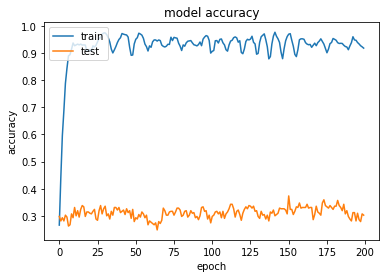

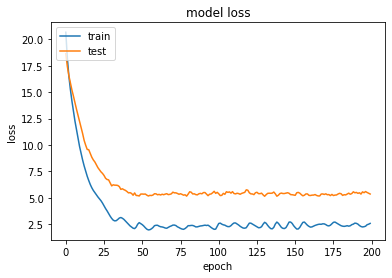

0.3227990970654628
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 22, 256)           1156096   
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                180256    
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None,

In [11]:
def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = rnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = RNN(x_train,y_train,x_test,y_test)